In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pybaselines import Baseline

### Load XP spectra

In [30]:
filepath = "data/XP_spectra.par"
fluxes = pd.read_parquet(filepath)
print(filepath)

# Extract names of wavelength columns and the wavelength values
column_names = fluxes.columns.values
wvl_columns = column_names[1:]
wvl_values = wvl_columns.astype("float64")

fluxes

data/XP_spectra.par


,GaiaEDR3,400.0,402.0,404.0,406.0,408.0,410.0,412.0,414.0,416.0,...,932.0,934.0,936.0,938.0,940.0,942.0,944.0,946.0,948.0,950.0
0,1306361548360576,0.880664,0.956566,1.000000,0.971906,0.894380,0.822738,0.798581,0.825152,0.865528,...,0.053590,0.053262,0.052726,0.052064,0.050955,0.049747,0.049108,0.047820,0.046919,0.046797
1,1792620565667968,0.975317,1.000000,0.990138,0.952763,0.912366,0.889294,0.886904,0.897504,0.902722,...,0.055039,0.055681,0.055933,0.055857,0.055100,0.054040,0.053420,0.051942,0.050762,0.050329
2,6052403489630720,0.989234,0.999677,1.000000,0.981486,0.952358,0.927282,0.915479,0.919519,0.927211,...,0.051657,0.051641,0.051316,0.050749,0.049630,0.048316,0.047482,0.045985,0.044864,0.044519
3,6353119919810816,0.946262,0.990099,1.000000,0.968097,0.916363,0.876562,0.867044,0.886604,0.911547,...,0.073482,0.073721,0.073568,0.073105,0.071860,0.070320,0.069438,0.067515,0.066047,0.065614
4,10844075163628928,0.945752,0.994626,1.000000,0.961210,0.908435,0.875509,0.875726,0.900652,0.922979,...,0.097100,0.097349,0.097130,0.096563,0.095025,0.093141,0.092156,0.089785,0.087983,0.087496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20069,6916087950150111232,0.965012,0.991227,1.000000,0.982385,0.943796,0.902484,0.879445,0.888807,0.919896,...,0.080179,0.080430,0.080267,0.079788,0.078484,0.076881,0.076018,0.074022,0.072521,0.072138
20070,6916186184642798848,0.965901,1.000000,0.996035,0.955809,0.907155,0.878344,0.877706,0.895503,0.906945,...,0.048346,0.048598,0.048845,0.049053,0.048821,0.048410,0.048452,0.047757,0.047371,0.047716
20071,6916517859197240320,0.986100,0.998334,1.000000,0.980757,0.942764,0.901419,0.876576,0.882764,0.910092,...,0.055705,0.055578,0.055155,0.054512,0.053315,0.051940,0.051105,0.049567,0.048434,0.048128
20072,6916925361398340096,0.988424,0.995600,1.000000,0.988705,0.960237,0.925046,0.898263,0.892819,0.901821,...,0.055831,0.055897,0.055641,0.055124,0.053994,0.052626,0.051746,0.050099,0.048819,0.048343


In [31]:
def extract_individual_spectrum(GaiaEDR3):

    row = fluxes[fluxes["GaiaEDR3"] == GaiaEDR3]

    flx = row[wvl_columns].values[0]

    return pd.DataFrame({"wvl": wvl_values, "flx": flx})

#### Plot randomly selected XP spectra

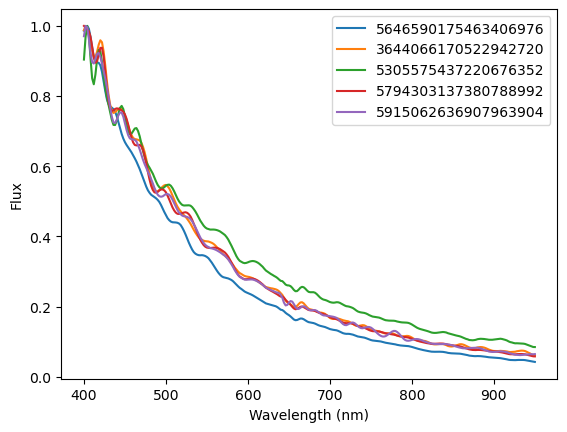

In [32]:
n_plot = 5

for GaiaEDR3 in fluxes["GaiaEDR3"].sample(n_plot):
    
    spec = extract_individual_spectrum(GaiaEDR3)
    plt.plot(spec["wvl"], spec["flx"], label=GaiaEDR3)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux")
plt.legend()
plt.show()

In [33]:
def normalize(spec, plot):

    # Fit continuum baseline to spectrum
    baseline_fitter = Baseline(x_data=wvl_values)
    spec["baseline"], _ = baseline_fitter.asls(-spec["flx"], lam=1, p=10e-4)
    
    # Normalize by dividing by baseline
    spec["flx_norm"] = -spec["flx"] / spec["baseline"]

    if plot:
        # Plot
        plt.title(GaiaEDR3)
        plt.plot(spec["wvl"], spec["flx"], label="Original")
        plt.plot(spec["wvl"], -spec["baseline"], label="Baseline")
        plt.plot(spec["wvl"], spec["flx_norm"], label="Normalized")

        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Flux")
        plt.legend()
        plt.show()

    return spec[["wvl", "flx_norm"]]

### Normalize all spectra

Store normalized spectra in data frame of same shape as original spectra data frame

In [36]:
# Array that will be filled with normalized spectra
flx_norm = np.empty(shape=(fluxes.shape[0], fluxes.shape[1] - 1))

for i, GaiaEDR3 in enumerate(fluxes["GaiaEDR3"]):

    # Show progress
    if (i > 0) & (i % 1000 == 0):
        print(f"{i} spectra done")

    spec = extract_individual_spectrum(GaiaEDR3)
    spec = normalize(spec, plot=False)    # Set plot=True only if number of spectra is small (<~10)

    # Add normalized fluxes to array
    flx_norm[i, :] = spec["flx_norm"].values

# Convert array to data frame and add GaiaEDR3 columns
fluxes_norm = pd.DataFrame(flx_norm, columns=wvl_columns)
fluxes_norm.insert(loc=0, column="GaiaEDR3", value=fluxes["GaiaEDR3"])

fluxes_norm

1000 spectra done
2000 spectra done
3000 spectra done
4000 spectra done
5000 spectra done
6000 spectra done
7000 spectra done
8000 spectra done
9000 spectra done
10000 spectra done
11000 spectra done
12000 spectra done
13000 spectra done
14000 spectra done
15000 spectra done
16000 spectra done
17000 spectra done
18000 spectra done
19000 spectra done
20000 spectra done


,GaiaEDR3,400.0,402.0,404.0,406.0,408.0,410.0,412.0,414.0,416.0,...,932.0,934.0,936.0,938.0,940.0,942.0,944.0,946.0,948.0,950.0
0,1306361548360576,0.853450,0.941675,1.000411,0.988710,0.925614,0.866464,0.855969,0.900321,0.961643,...,0.993973,0.998679,1.000135,0.999833,0.991327,0.981020,0.982047,0.970091,0.965854,0.977762
1,1792620565667968,0.959502,0.996733,1.000108,0.975493,0.947082,0.936094,0.946869,0.972096,0.992361,...,0.989064,0.997809,1.000719,0.999373,0.987119,0.970374,0.962181,0.938859,0.921021,0.916727
2,6052403489630720,0.974929,0.992400,1.000032,0.988859,0.966801,0.948620,0.943953,0.955887,0.972213,...,0.988757,0.997123,1.000409,1.000030,0.989502,0.975452,0.971328,0.953621,0.943489,0.949665
3,6353119919810816,0.928566,0.980801,1.000170,0.977861,0.934958,0.903505,0.902977,0.933175,0.970096,...,0.988380,0.996614,1.000155,1.000293,0.990562,0.977249,0.973427,0.955111,0.943117,0.945857
4,10844075163628928,0.927307,0.984887,1.000189,0.971341,0.927670,0.903547,0.913471,0.949748,0.984329,...,0.990076,0.997219,1.000149,1.000254,0.991048,0.978711,0.976138,0.958996,0.947835,0.950827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20069,6916087950150111232,0.953987,0.982351,0.993574,0.978676,0.942920,0.904479,0.884542,0.897774,0.934133,...,0.990458,0.997577,1.000323,1.000104,0.990335,0.977298,0.974000,0.956321,0.944928,0.948095
20070,6916186184642798848,0.944458,0.990766,1.000156,0.973015,0.936448,0.919586,0.932130,0.964952,0.992000,...,0.937379,0.953363,0.968575,0.982308,0.986486,0.986290,0.994723,0.987531,0.986288,1.000191
20071,6916517859197240320,0.965473,0.982872,0.990037,0.976551,0.944274,0.908453,0.889263,0.902068,0.937744,...,0.990237,0.997536,1.000324,1.000031,0.990184,0.977328,0.974813,0.958878,0.950554,0.958498
20072,6916925361398340096,0.969359,0.985898,1.000017,0.998645,0.979826,0.953819,0.936201,0.940956,0.961661,...,0.988196,0.996699,1.000288,1.000183,0.989802,0.975520,0.970561,0.951265,0.938701,0.941522


### Save data frame to parquet file

In [37]:
filepath = "data/XP_spectra_norm.par"
fluxes_norm[wvl_columns] = fluxes_norm[wvl_columns].astype("float32")
fluxes_norm.to_parquet(filepath, index=False, compression="brotli")
print(filepath)

data/XP_spectra_norm.par
